In [2]:
from atlite.gis import ExclusionContainer
import atlite
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import rasterio.crs as crs
import cartopy.crs as ccrs
from shapely.geometry import MultiPolygon, Polygon
from atlite.gis import shape_availability
import rasterio
import xarray as xr
from pyproj import CRS
import seaborn as sns
import matplotlib.lines as mlines

In [3]:
os.chdir("C:\\Users\\alex-\\Documents\\TU Berlin\\EW_Mod\\EW_Mod_Paper")
url = "https://tubcloud.tu-berlin.de/s/RHZJrN8Dnfn26nr/download/NUTS_RG_10M_2021_4326.geojson"
nuts = gpd.read_file(url)
nuts = nuts.query("LEVL_CODE == 1")
nuts = nuts[nuts["CNTR_CODE"].isin(["DE"])]  # Filter for Germany)]  


C:\Users\alex-\AppData\Local\Temp\ipykernel_25744\624608355.py:30: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
C:\Users\alex-\AppData\Local\Temp\ipykernel_25744\624608355.py:57: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


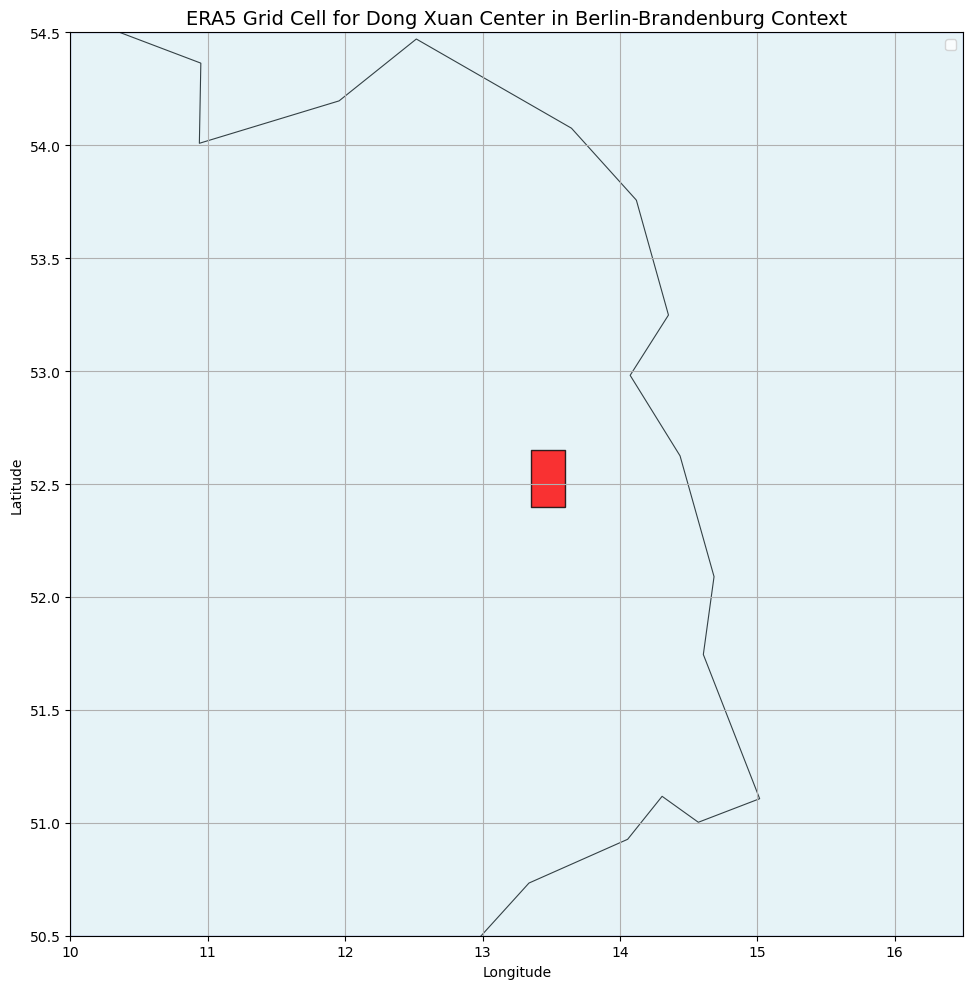

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import math


# 1. Snap Dong Xuan coordinates to ERA5 0.25° grid
def snap_to_grid(coord, resolution=0.25, direction='lower'):
    if direction == 'lower':
        return math.floor(coord / resolution) * resolution
    elif direction == 'upper':
        return math.ceil(coord / resolution) * resolution

# Define grid buffer (in degrees)
buffer_deg = 0.1

# Apply buffer to the snapped coordinates
minx = snap_to_grid(lon, 0.05, 'lower') - buffer_deg
maxx = snap_to_grid(lon, 0.05, 'upper') + buffer_deg
miny = snap_to_grid(lat, 0.05, 'lower') - buffer_deg
maxy = snap_to_grid(lat, 0.05, 'upper') + buffer_deg

# Recreate the expanded ERA5 grid cell
dongxuan_cell = gpd.GeoDataFrame(
    geometry=[box(minx, miny, maxx, maxy)],
    crs="EPSG:4326"
)

# 3. Load the Germany base map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
germany = world[world.name == "Germany"]

# 4. Define Berlin/Brandenburg bounding box as GeoDataFrame
bbox_dict = {
    "minx": 10.0,
    "miny": 50.5,
    "maxx": 16.5,
    "maxy": 54.5,
}
bbox_geom = box(bbox_dict["minx"], bbox_dict["miny"], bbox_dict["maxx"], bbox_dict["maxy"])
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs="EPSG:4326")

# 5. Plot everything in one figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

germany.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8)
bbox_gdf.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.3, label='Berlin-Brandenburg BBox')
dongxuan_cell.plot(ax=ax, color='red', edgecolor='black', alpha=0.8, label='Dong Xuan ERA5 Cell')

# 6. Set extent and styling
ax.set_xlim(bbox_dict["minx"], bbox_dict["maxx"])
ax.set_ylim(bbox_dict["miny"], bbox_dict["maxy"])
ax.set_title("ERA5 Grid Cell for Dong Xuan Center in Berlin-Brandenburg Context", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


### Preparing Atlite Cutout

In [ ]:
from datetime import datetime

for month in range(1, 13):
    month_str = str(month).zfill(2)
    first_day = f"2023-{month_str}-01"
    last_day = f"2023-{month_str}-{calendar.monthrange(2023, month)[1]}"
    time_range = slice(first_day, last_day)  # ← Correct format

    print(f"Creating cutout for {month_str}/2023...")

    cutout = atlite.Cutout(
        path=output_folder / f"dongxuan_2023_{month_str}.nc",
        module="era5",
        x=x_slice,
        y=y_slice,
        time=time_range,
    )

    cutout.prepare(
        overwrite=True,
        tmpdir=tmpdir
    )

    print(f"✅ Cutout for {month_str}/2023 successfully created and saved.")

Creating cutout for 01/2023...
